<a href="https://colab.research.google.com/github/ajayrajput86/prediction-of-house-value/blob/main/Surprise_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [973]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [974]:
# Importing all require lib

In [975]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score 
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

pd.set_option('display.max_rows', None)
import warnings

# Ignore DeprecationWarning and FutureWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [976]:
# reading raw data
raw_data=pd.read_csv("/content/drive/MyDrive/upgrad/Advanced Regression/train.csv",encoding = 'utf-8')
print(raw_data.shape)


(1460, 81)


In [977]:
raw_data.nunique().sort_values()

CentralAir          2
Utilities           2
Street              2
Alley               2
BsmtHalfBath        3
LandSlope           3
GarageFinish        3
HalfBath            3
PavedDrive          3
PoolQC              3
FullBath            4
MasVnrType          4
BsmtExposure        4
ExterQual           4
MiscFeature         4
BsmtFullBath        4
Fence               4
KitchenQual         4
BsmtCond            4
Fireplaces          4
LandContour         4
LotShape            4
KitchenAbvGr        4
BsmtQual            4
FireplaceQu         5
Electrical          5
YrSold              5
GarageCars          5
GarageQual          5
GarageCond          5
HeatingQC           5
ExterCond           5
MSZoning            5
LotConfig           5
BldgType            5
BsmtFinType2        6
Foundation          6
RoofStyle           6
SaleCondition       6
GarageType          6
BsmtFinType1        6
Heating             6
Functional          7
RoofMatl            8
HouseStyle          8
Condition2

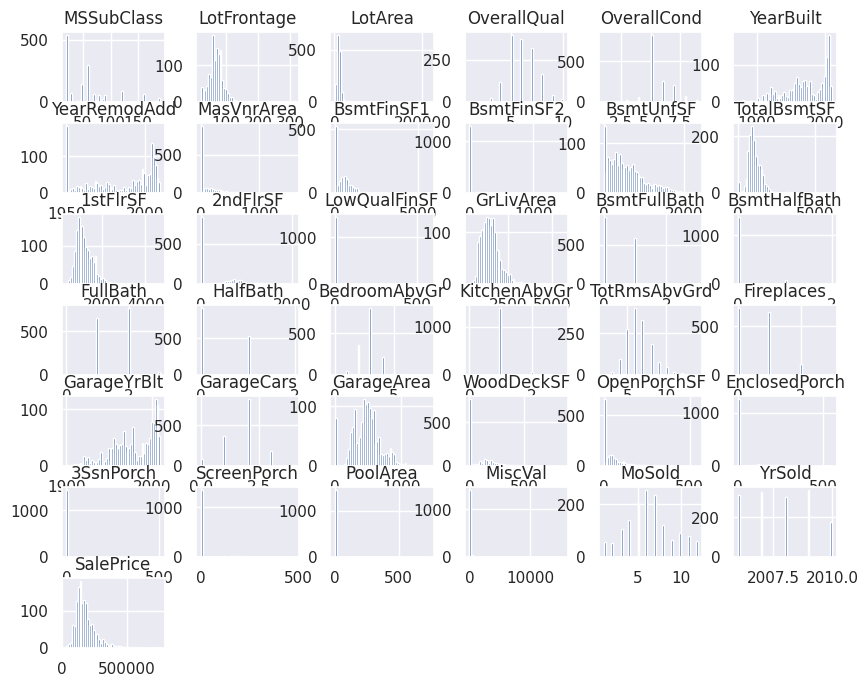

In [978]:
#Visualing input data pattern

raw_data=raw_data.drop(["Id"], axis=1 ) # removing ID column
raw_data.hist(bins=50, figsize=(10, 8))
plt.show()

In [979]:
data_numeric = raw_data.select_dtypes(include=['float64', 'int64'])
data_cate = raw_data.select_dtypes(include=["object"])


#cheking outlier in data set with box plot

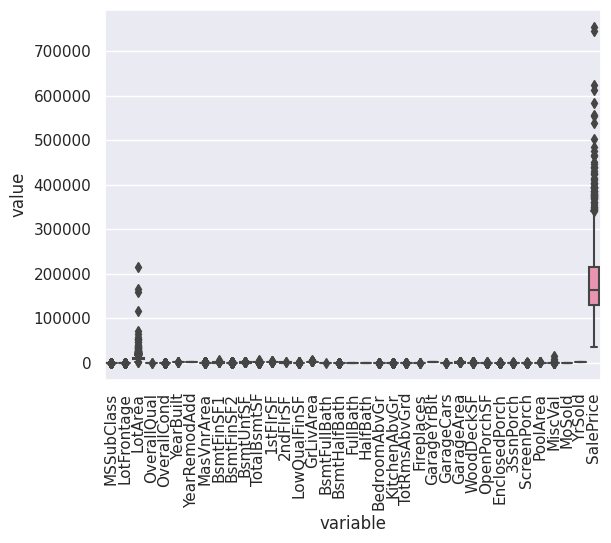

In [980]:

df_melted = pd.melt(data_numeric)

sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=90)
plt.show()
#clearly data as some outliers

### Removing Outlier with Q1=.05 and Q3=.95
### if we consider IQR multipler 1.5




In [981]:


# Filter numeric columns
numeric_columns = raw_data.select_dtypes(include=['int', 'float']).columns

# Calculate the lower and upper quartiles for numeric columns
Q1 = raw_data[numeric_columns].quantile(0.00)
Q3 = raw_data[numeric_columns].quantile(1)

# Calculate the interquartile range (IQR) for numeric columns
IQR = Q3 - Q1

# Define the multiplier to determine the outlier threshold (e.g., 1.5)
threshold_multiplier = 1

# Determine the lower and upper thresholds for outlier detection
lower_threshold = Q1 - threshold_multiplier * IQR
upper_threshold = Q3 + threshold_multiplier * IQR

# Identify outlier values in numeric columns
filtered_data = raw_data[~((raw_data[numeric_columns] < lower_threshold) | (raw_data[numeric_columns] > upper_threshold)).any(axis=1)]

# Print the outlier values
filtered_data.shape


(1460, 80)

In [982]:
#  Property Age from yearsold - yearbuilt
filtered_data['PropAge'] = (filtered_data['YrSold'] - filtered_data['YearBuilt'])
#droping redendent col 
filtered_data = filtered_data.drop(['MoSold'], axis = 1)
filtered_data = filtered_data.drop(['YrSold'], axis = 1)
filtered_data = filtered_data.drop(['YearBuilt'], axis = 1)
filtered_data = filtered_data.drop(['YearRemodAdd'], axis = 1)

# Working on missing values

---



<Axes: title={'center': 'missing values visualization'}>

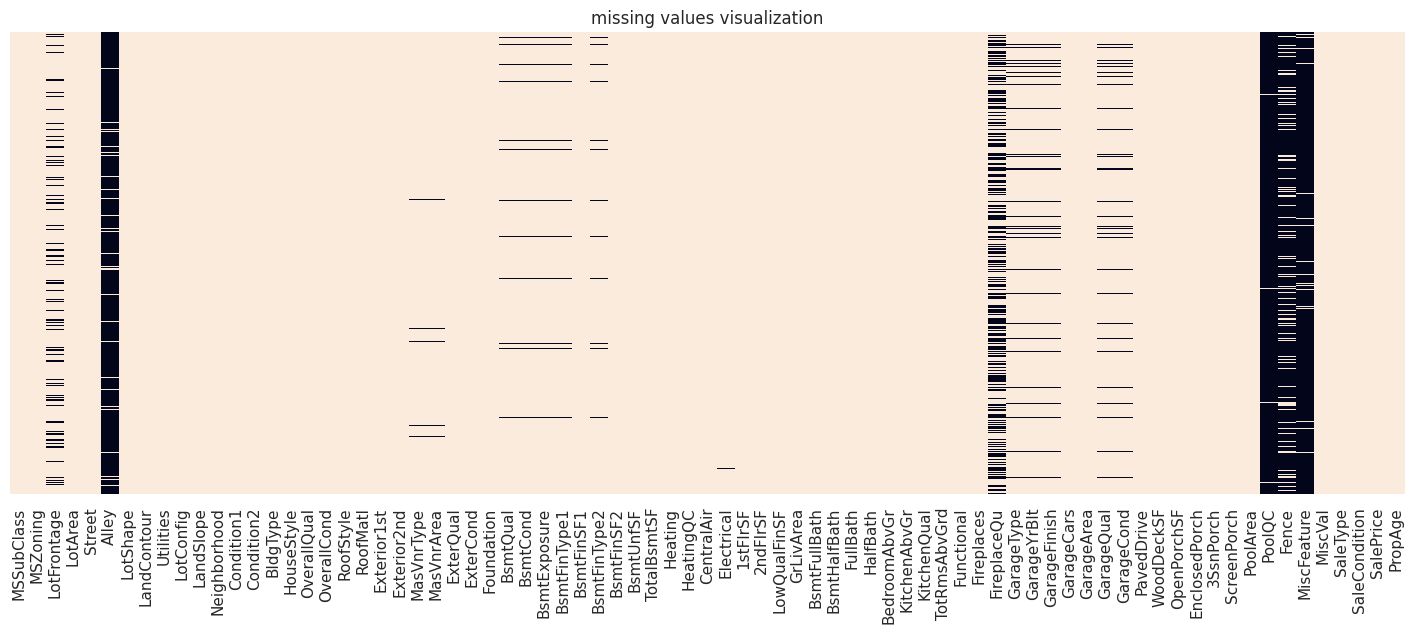

In [983]:
# visualizing missing values with heat map
plt.figure(figsize=(18,6))
plt.title('missing values visualization')
sns.heatmap(filtered_data.isnull(),yticklabels=False,cbar=False,cmap='rocket_r')



In [984]:
##  coverting GarageType
filtered_data['GarageYrBlt'] = pd.to_numeric(filtered_data['GarageYrBlt'], errors='coerce').astype(pd.Int64Dtype())

In [985]:
# missing value count in percent term 
(filtered_data.isnull().mean()*100).sort_values(ascending=False).head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageYrBlt      5.547945
GarageType       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
MSSubClass       0.000000
dtype: float64

In [986]:
# cant drop these column with high missing count , as they will greatly change house price 
null_col = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageCond","GarageType","GarageFinish","GarageQual","BsmtFinType2","BsmtExposure","BsmtQual","BsmtCond" ,"BsmtFinType1","MasVnrType"]
for col in null_col:
    filtered_data[col].fillna("none", inplace=True)

In [987]:
#GarageYrBlt with null value , belongs house where garage in not availble 
# So replace GarageYrBlt with 0
filtered_data["GarageYrBlt"].fillna(0, inplace=True)

In [988]:
# LotFrontage be imputed with similar 'Neighborhood' 

filtered_data['LotFrontage'] = filtered_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [989]:
# Replace  "MasVnrArea" col null value with mode 
filtered_data["MasVnrArea"].fillna(filtered_data["MasVnrArea"].median(), inplace=True)
filtered_data["Electrical"].fillna(filtered_data["Electrical"].mode(), inplace=True)


In [990]:
(filtered_data.isnull().mean()*100).sort_values(ascending=False).head(20)

Electrical      0.068493
MSSubClass      0.000000
KitchenAbvGr    0.000000
GarageYrBlt     0.000000
GarageType      0.000000
FireplaceQu     0.000000
Fireplaces      0.000000
Functional      0.000000
TotRmsAbvGrd    0.000000
KitchenQual     0.000000
BedroomAbvGr    0.000000
HalfBath        0.000000
FullBath        0.000000
BsmtHalfBath    0.000000
BsmtFullBath    0.000000
GrLivArea       0.000000
LowQualFinSF    0.000000
2ndFlrSF        0.000000
GarageFinish    0.000000
GarageCars      0.000000
dtype: float64

In [991]:
##  removing this part as graphic not supported on github
'''!pip install sweetviz 
import sweetviz as sv
# Generate the report
report = sv.analyze(data_ex_null)
report.show_html("./report.html")'''

'!pip install sweetviz \nimport sweetviz as sv\n# Generate the report\nreport = sv.analyze(data_ex_null)\nreport.show_html("./report.html")'

In [992]:
##  removing this part as graphic not supported on github
'''
from IPython.display import display, HTML

html_file_path = '/content/drive/MyDrive/upgrad/Advanced Regression/report.html'

# Read the HTML file
with open(html_file_path, 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))'''

"\nfrom IPython.display import display, HTML\n\nhtml_file_path = '/content/drive/MyDrive/upgrad/Advanced Regression/report.html'\n\n# Read the HTML file\nwith open(html_file_path, 'r') as file:\n    html_content = file.read()\n\n# Display the HTML content\ndisplay(HTML(html_content))"

## EDA Part

## Converting some 

In [993]:
#converting from int type to object to treat the variables as categorical variables

filtered_data['GarageCars'] = filtered_data['GarageCars'].astype('object')
filtered_data['Fireplaces'] = filtered_data['Fireplaces'].astype('object')
filtered_data['TotRmsAbvGrd'] = filtered_data['TotRmsAbvGrd'].astype('object')
filtered_data['KitchenAbvGr'] = filtered_data['KitchenAbvGr'].astype('object')
filtered_data['BedroomAbvGr'] = filtered_data['BedroomAbvGr'].astype('object')
filtered_data['HalfBath'] = filtered_data['HalfBath'].astype('object')
filtered_data['FullBath'] = filtered_data['FullBath'].astype('object')
filtered_data['BsmtHalfBath'] = filtered_data['BsmtHalfBath'].astype('object')
filtered_data['BsmtFullBath'] = filtered_data['BsmtFullBath'].astype('object')
filtered_data['OverallCond'] = filtered_data['OverallCond'].astype('object')
filtered_data['OverallQual'] = filtered_data['OverallQual'].astype('object')
filtered_data['MSSubClass'] = filtered_data['MSSubClass'].astype('object')


In [994]:
#converting year to number of years


filtered_data['GarageYrBlt'] = 2019 - filtered_data['GarageYrBlt']



In [995]:
Cat_col=filtered_data.select_dtypes(include='object').columns
num_col=filtered_data.select_dtypes(exclude='object').columns
print(Cat_col)
print(num_col)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFin

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

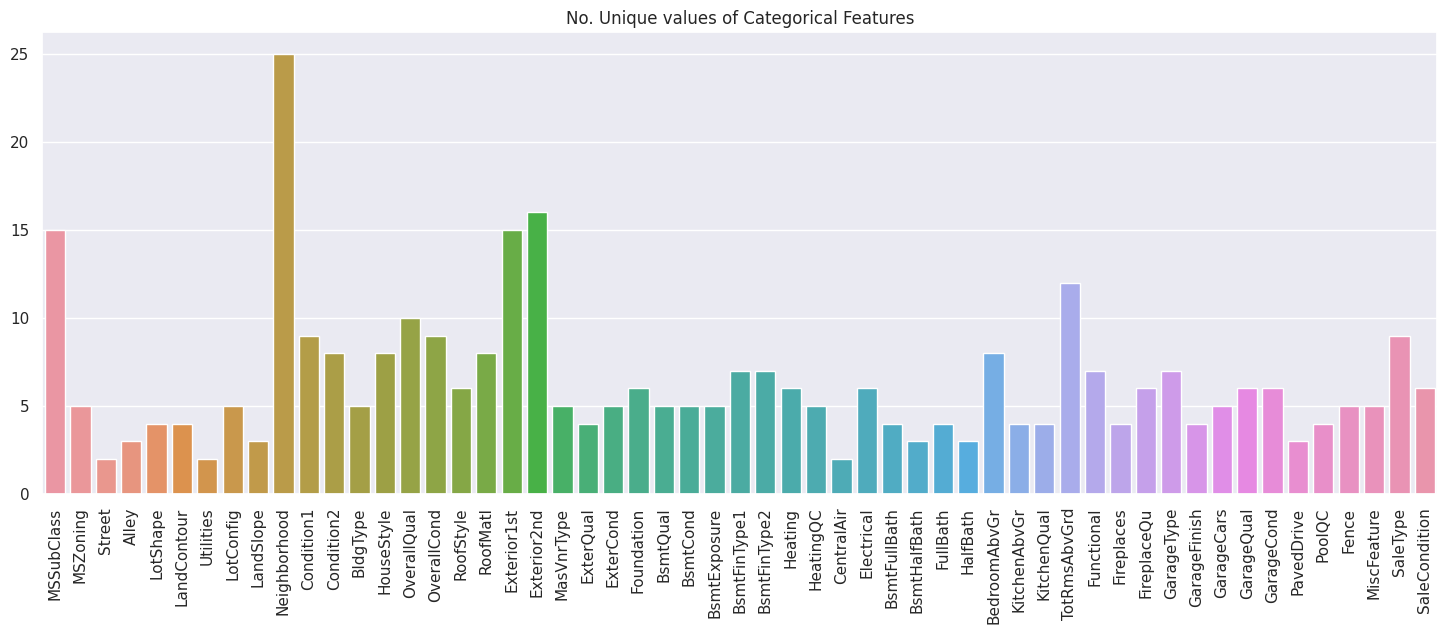

In [996]:
## checking unique count of catagorical data
dist_value = []
for col in Cat_col:
  dist_value.append(filtered_data[col].unique().size)
plt.figure(figsize=(18,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=Cat_col,y=dist_value)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

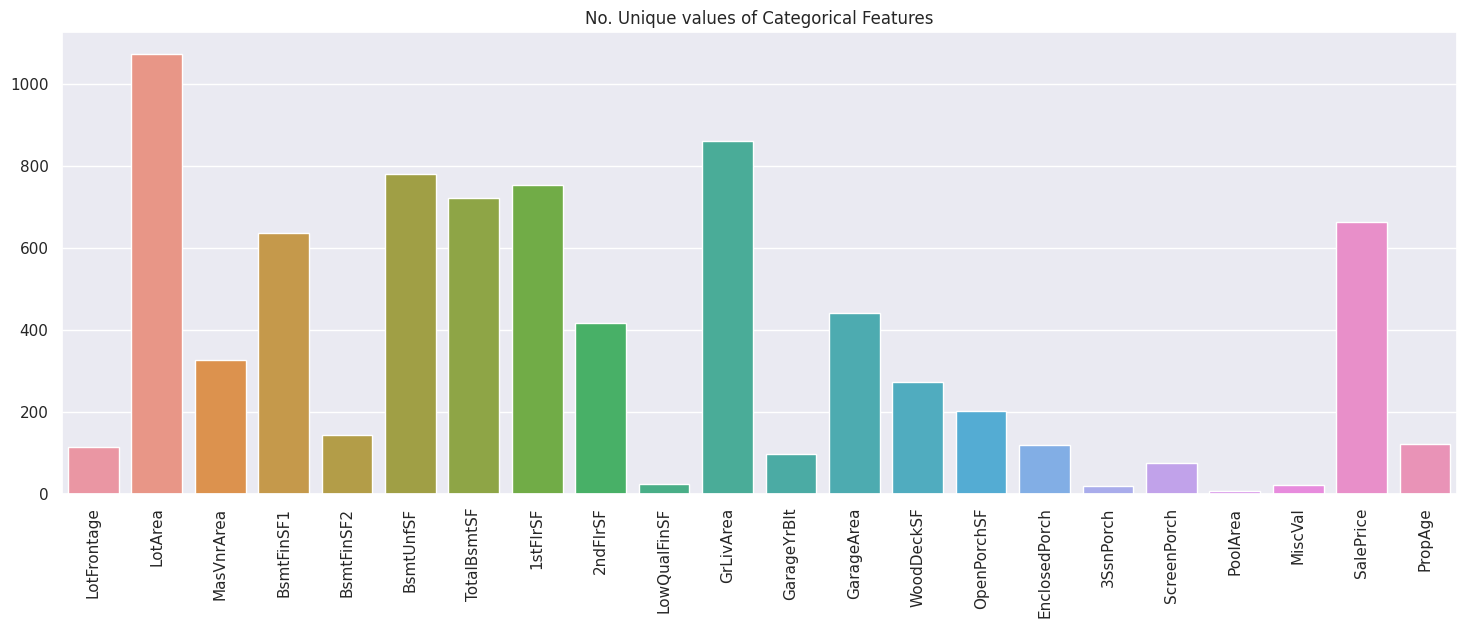

In [997]:
## checking unique count of numerical data
dist_value = []
for col in num_col:
  dist_value.append(filtered_data[col].unique().size)
plt.figure(figsize=(18,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(y= dist_value,x=num_col)

In [998]:
#corr 
corr=filtered_data.corr()
corr

LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
LotFrontage       1.000000  0.335957    0.195830    0.232576    0.052237   
LotArea           0.335957  1.000000    0.103321    0.214103    0.111170   
MasVnrArea        0.195830  0.103321    1.000000    0.261256   -0.071330   
BsmtFinSF1        0.232576  0.214103    0.261256    1.000000   -0.050117   
BsmtFinSF2        0.052237  0.111170   -0.071330   -0.050117    1.000000   
BsmtUnfSF         0.119174 -0.002618    0.113862   -0.495251   -0.209294   
TotalBsmtSF       0.381038  0.260833    0.360067    0.522396    0.104810   
1stFlrSF          0.434109  0.299475    0.339850    0.445863    0.097117   
2ndFlrSF          0.075686  0.050986    0.173800   -0.137079   -0.099260   
LowQualFinSF      0.031873  0.004779   -0.068628   -0.064503    0.014807   
GrLivArea         0.385190  0.263116    0.388052    0.208171   -0.009640   
GarageYrBlt      -0.104865 -0.072599   -0.132696   -0.115843   -0.035070   
GarageArea        0.339085  0.180403    0.370884    0.296970   -0.018227   
WoodDeckSF        0.088736  0.171698    0.159991    0.204306    0.067898   
OpenPorchSF       0.141734  0.084774    0.122528    0.111761    0.003093   
EnclosedPorch     0.008057 -0.018340   -0.109907   -0.102303    0.036543   
3SsnPorch         0.064654  0.020423    0.019144    0.026451   -0.029993   
ScreenPorch       0.041063  0.043160    0.062248    0.062021    0.088871   
PoolArea          0.174567  0.077672    0.011928    0.140491    0.041709   
MiscVal           0.005332  0.038068   -0.029512    0.003571    0.004940   
SalePrice         0.349876  0.263843    0.472614    0.386420   -0.011378   
PropAge          -0.120601 -0.014832   -0.311479   -0.248483    0.050422   

               BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  \
LotFrontage     0.119174     0.381038  0.434109  0.075686      0.031873  ...   
LotArea        -0.002618     0.260833  0.299475  0.050986      0.004779  ...   
MasVnrArea      0.113862     0.360067  0.339850  0.173800     -0.068628  ...   
BsmtFinSF1     -0.495251     0.522396  0.445863 -0.137079     -0.064503  ...   
BsmtFinSF2     -0.209294     0.104810  0.097117 -0.099260      0.014807  ...   
BsmtUnfSF       1.000000     0.415360  0.317987  0.004469      0.028167  ...   
TotalBsmtSF     0.415360     1.000000  0.819530 -0.174512     -0.033245  ...   
1stFlrSF        0.317987     0.819530  1.000000 -0.202646     -0.014241  ...   
2ndFlrSF        0.004469    -0.174512 -0.202646  1.000000      0.063353  ...   
LowQualFinSF    0.028167    -0.033245 -0.014241  0.063353      1.000000  ...   
GrLivArea       0.240257     0.454868  0.566024  0.687501      0.134683  ...   
GarageYrBlt    -0.042720    -0.176359 -0.166642 -0.064402      0.146467  ...   
GarageArea      0.183303     0.486665  0.489782  0.138347     -0.067601  ...   
WoodDeckSF     -0.005316     0.232019  0.235459  0.092165     -0.025444  ...   
OpenPorchSF     0.129005     0.247264  0.211671  0.208026      0.018251  ...   
EnclosedPorch  -0.002538    -0.095478 -0.065292  0.061989      0.061081  ...   
3SsnPorch       0.020764     0.037384  0.056104 -0.024358     -0.004296  ...   
ScreenPorch    -0.012579     0.084489  0.088758  0.040606      0.026799  ...   
PoolArea       -0.035092     0.126053  0.131525  0.081487      0.062157  ...   
MiscVal        -0.023837    -0.018479 -0.021096  0.016197     -0.003793  ...   
SalePrice       0.214479     0.613581  0.605852  0.319334     -0.025606  ...   
PropAge        -0.150619    -0.391498 -0.282143 -0.011552      0.182228  ...   

               GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
LotFrontage      0.339085    0.088736     0.141734       0.008057   0.064654   
LotArea          0.180403    0.171698     0.084774      -0.018340   0.020423   
MasVnrArea       0.370884    0.159991     0.122528      -0.109907   0.019144   
BsmtFinSF1       0.296970    0.204306     0.111761      -0.102303   0.026451   
BsmtFinSF2      -0.018227

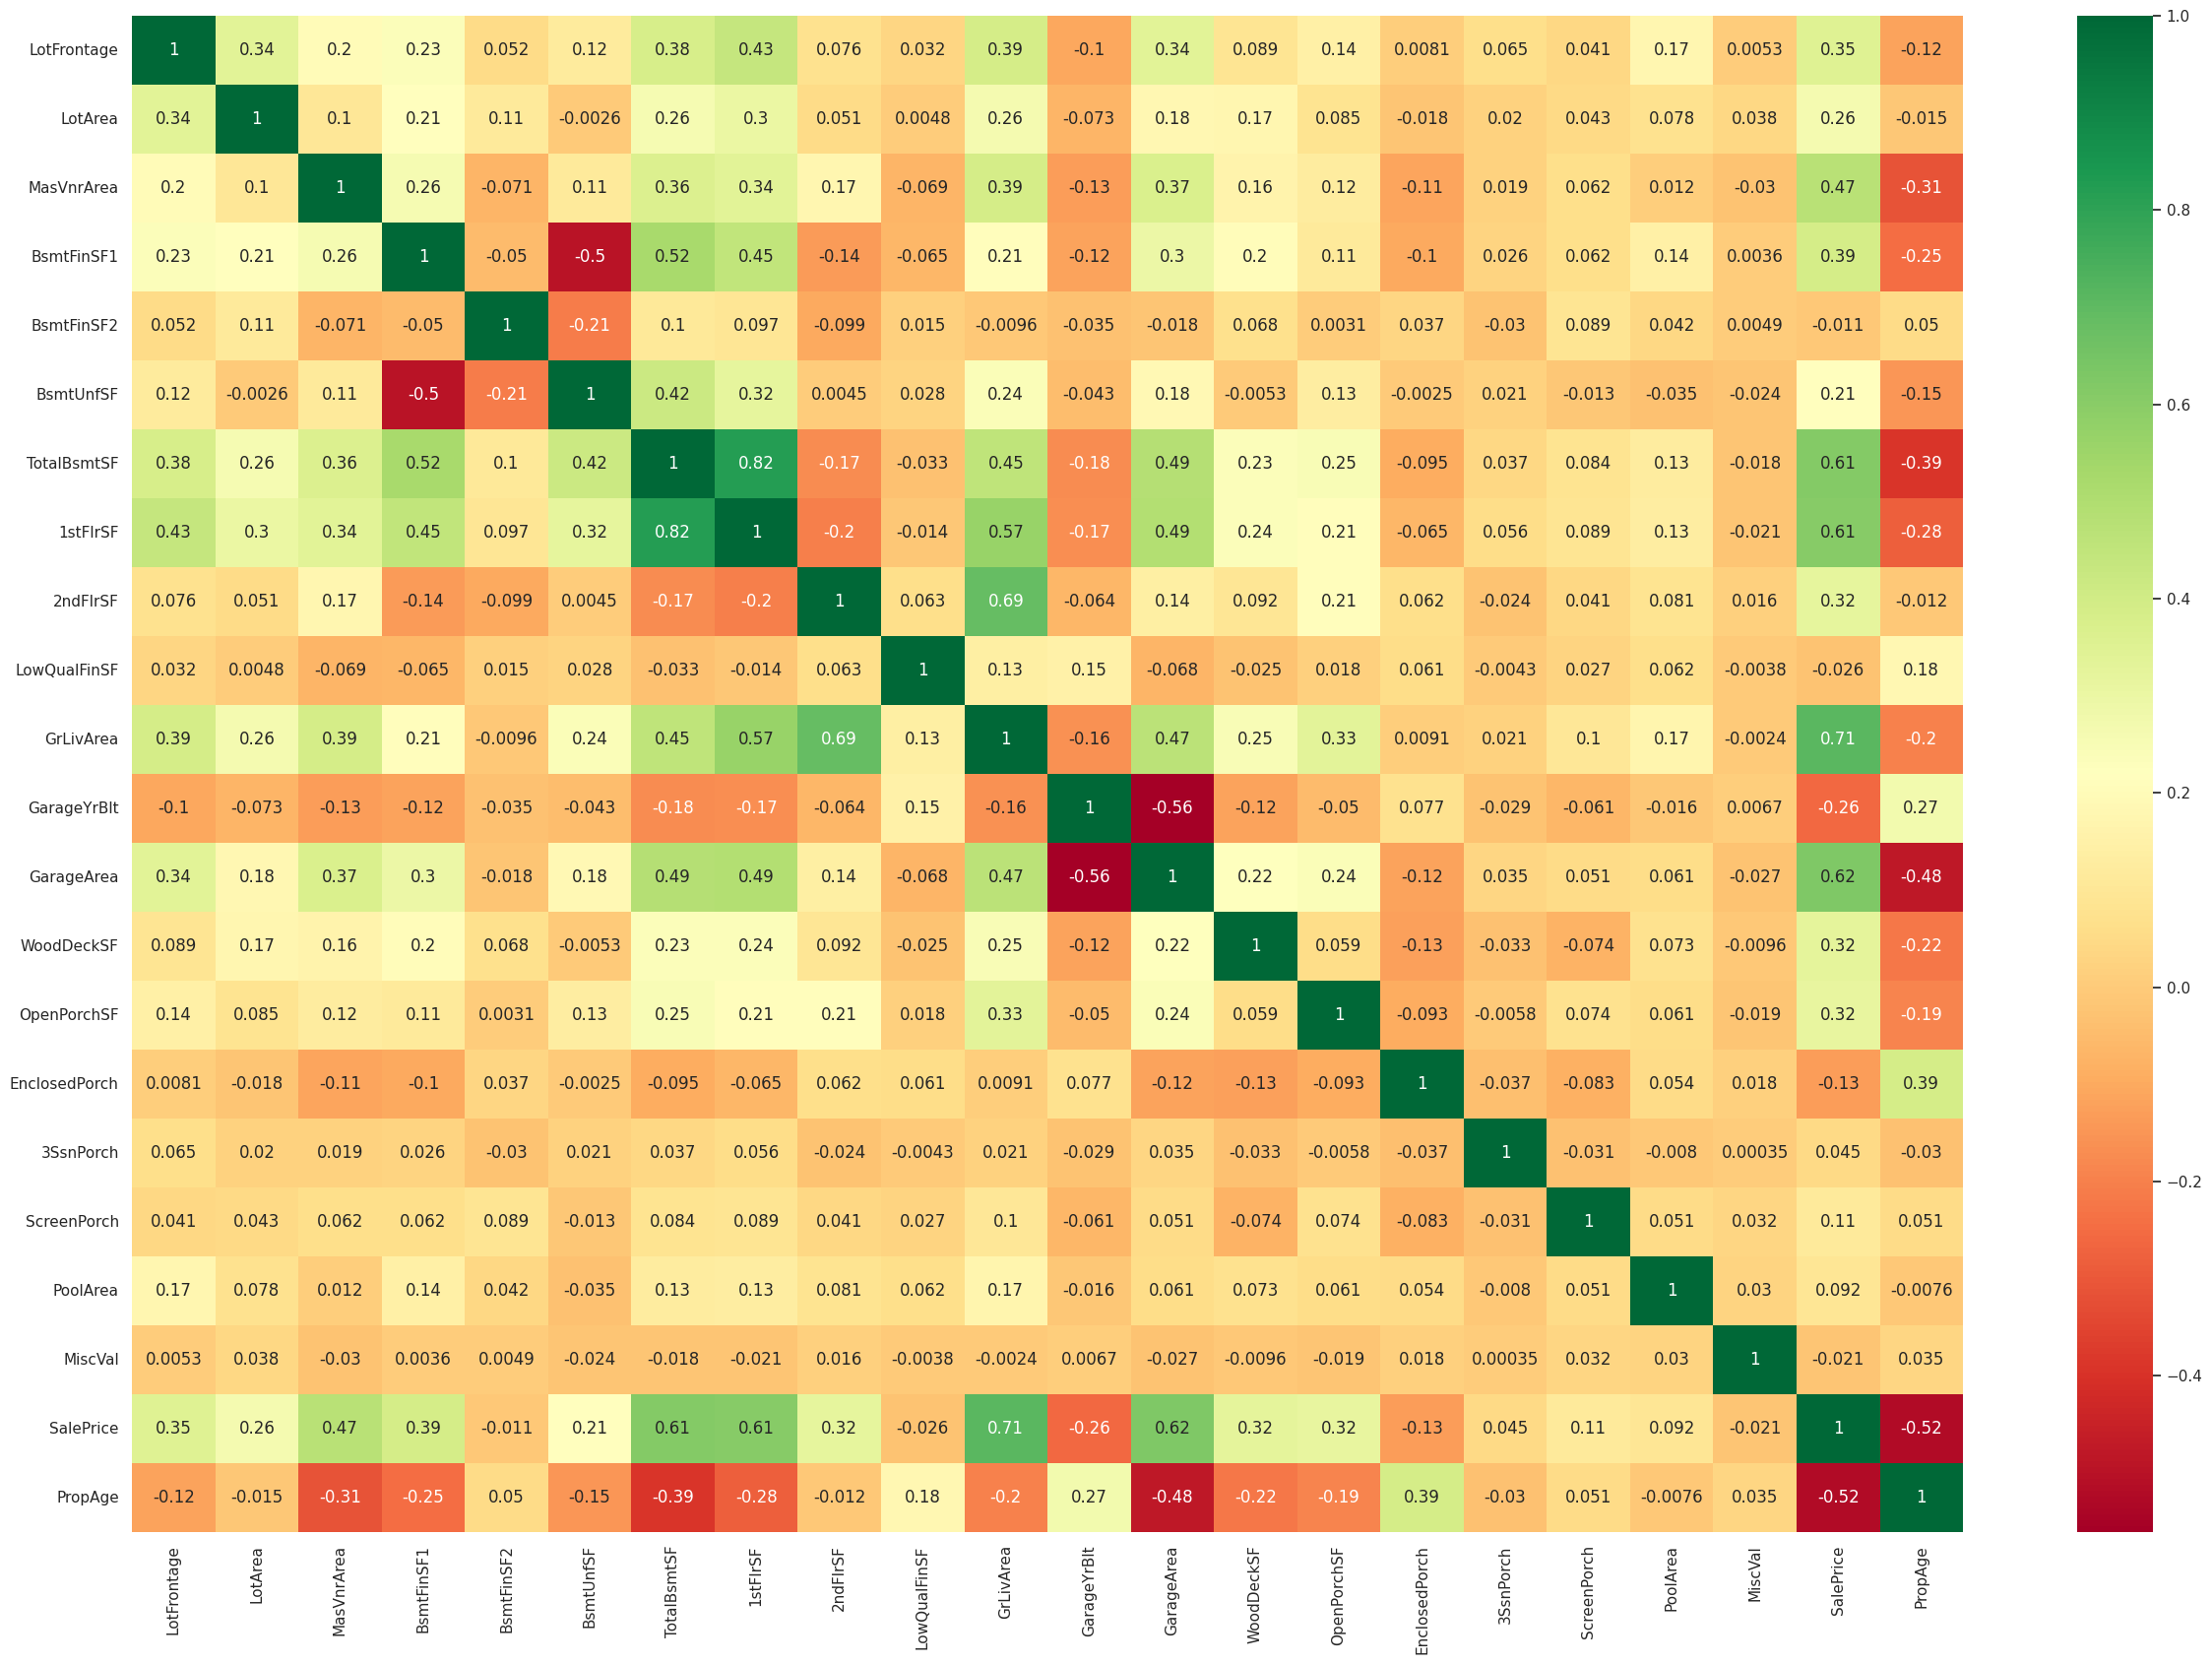

In [999]:
# plotting correlations on a heatmap

plt.figure(figsize=(30,20))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

## Notice some variable has high correlation

In [1000]:
threshold_min = 0.65
threshold_max=1.0
high_correlation_features = corr[(corr > threshold_min) & (corr < threshold_max)].stack().index.tolist()
high_correlation_features
## high correlation parameters

[('TotalBsmtSF', '1stFlrSF'),
 ('1stFlrSF', 'TotalBsmtSF'),
 ('2ndFlrSF', 'GrLivArea'),
 ('GrLivArea', '2ndFlrSF'),
 ('GrLivArea', 'SalePrice'),
 ('SalePrice', 'GrLivArea')]

In [1001]:
filtered_data[["TotalBsmtSF","1stFlrSF"]].corr()
# very high correlation between "1stFlrSF"  and "TotalBsmtSF"

TotalBsmtSF  1stFlrSF
TotalBsmtSF      1.00000   0.81953
1stFlrSF         0.81953   1.00000

In [1002]:
col=list(filtered_data.select_dtypes(exclude='object').columns)
col.pop()

print(col)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


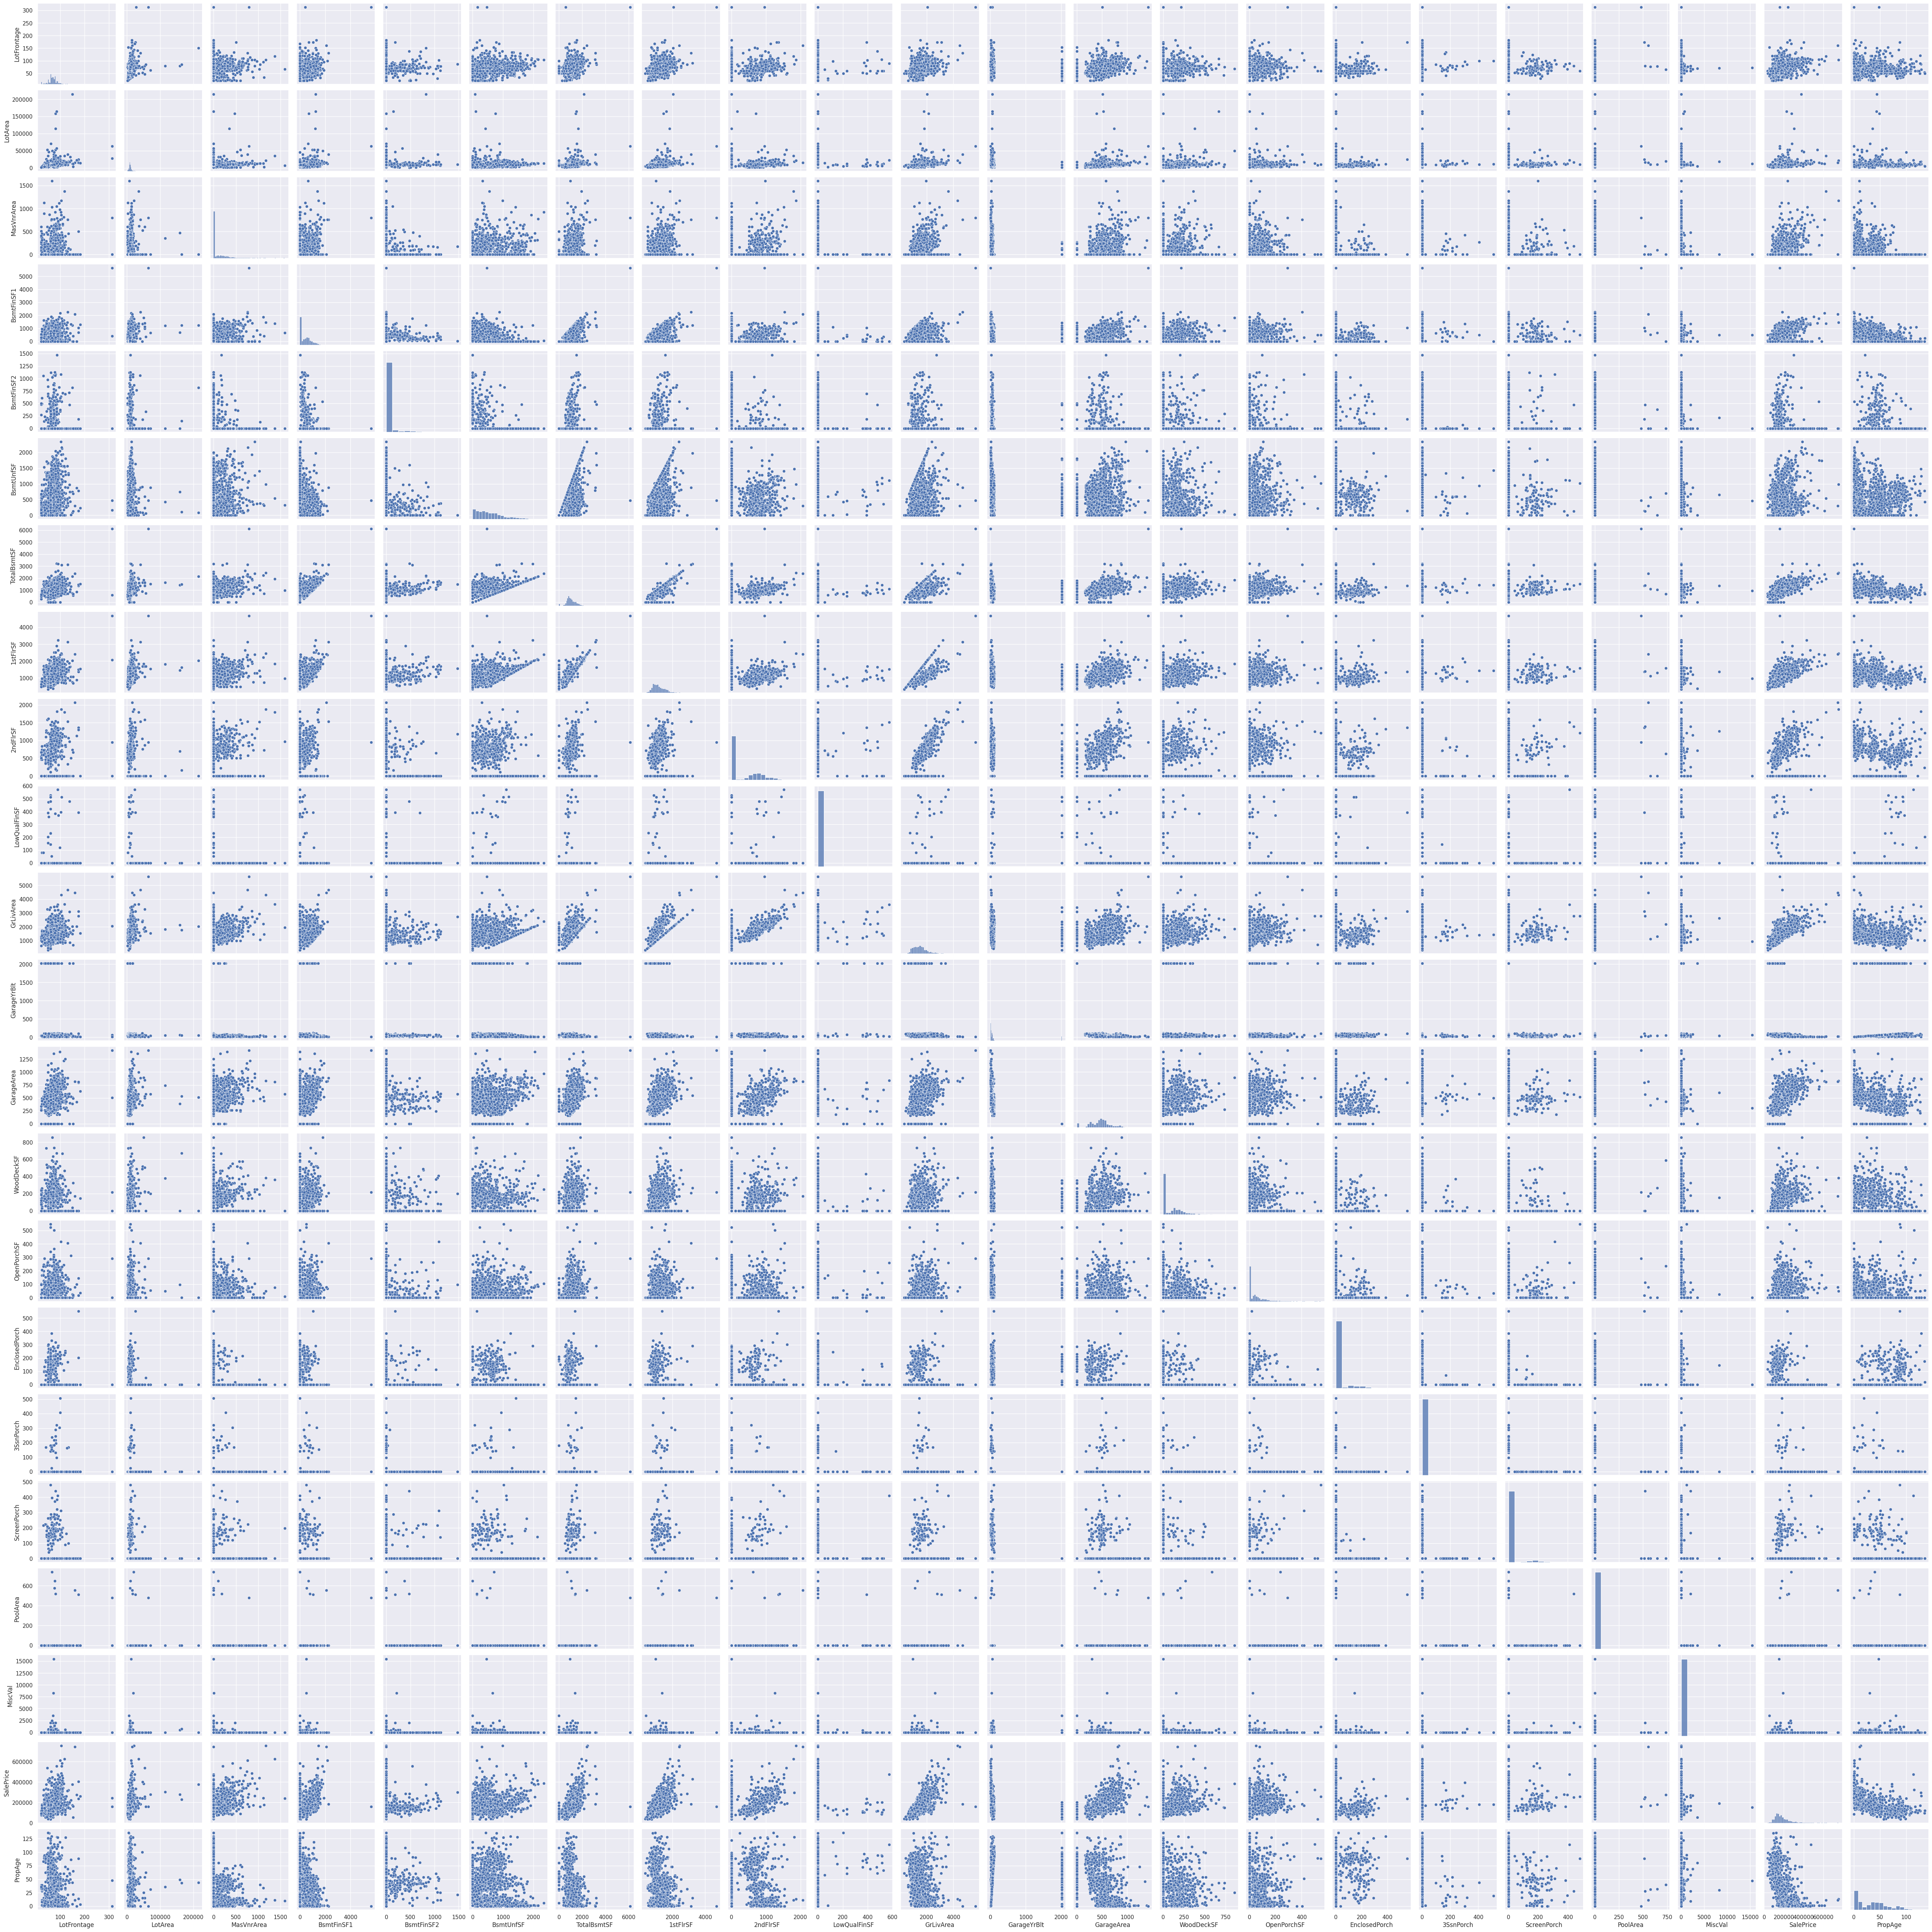

In [1003]:
num_col=filtered_data.select_dtypes(exclude='object').columns
sns.set()
#cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt']
sns.pairplot(filtered_data[num_col], size = 2.5)
plt.show()

## pair plot of feature vs sale_Price indicate that some feature does not have any correlation with sale_Price.
## here we will not dropthese feature 
## we will leave feature elemination to RFE process

# Convert categorical to numerical

In [1004]:

data = pd.get_dummies(filtered_data, drop_first=True )


# dependent variable split

In [1005]:


# Splitting the data into train and test
from sklearn.model_selection import train_test_split


# split data in to train and test
x_train,x_test=train_test_split(data,train_size=0.7,random_state=100)
x_train.shape,x_test.shape

((1021, 315), (439, 315))

In [1006]:

# dependent variable split
y_train = x_train.pop('SalePrice')
X_train = x_train

# dependent variable split
y_test = x_test.pop('SalePrice')
x_test= x_test

# Feature scaling with StandardScaler

In [1007]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
col=x_train.columns
x_train=scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=col)
x_train.head(10)


LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0     0.887747 -0.057261    0.809137    1.159065   -0.293313  -0.454262   
1    -0.806731 -0.169753   -0.558025   -0.761831   -0.293313   0.172244   
2    -0.494591 -0.502762   -0.558025   -0.964030   -0.293313  -0.175567   
3    -0.449999  0.082504   -0.558025   -0.964030   -0.293313   0.475464   
4    -0.895914 -0.202365   -0.558025   -0.445625    1.996400  -0.746334   
5    -0.227041 -0.204306    0.616880    0.315850   -0.293313  -0.387375   
6     0.397240  0.178301   -0.558025    2.135645   -0.293313  -1.134277   
7     0.129691 -0.188873    1.257736   -0.964030   -0.293313  -1.256903   
8    -0.405407 -0.313594   -0.558025    0.700889    0.585094  -1.025029   
9    -0.004084 -0.286806   -0.558025   -0.725263    1.340523  -0.093074   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  SaleType_ConLI  \
0     0.621091  0.511410  2.137583     -0.124502  ...       -0.054286   
1    -0.712611 -0.931882  0.793638     -0.124502  ...       -0.054286   
2    -1.257424 -0.421449  0.667284     -0.124502  ...       -0.054286   
3    -0.621082  0.194590  1.609195     -0.124502  ...       -0.054286   
4    -0.438025 -0.522027  0.143490     -0.124502  ...       -0.054286   
5    -0.167798 -0.461680 -0.789230     -0.124502  ...       -0.054286   
6     0.945799  0.823201  0.671879     -0.124502  ...       -0.054286   
7    -2.314361 -0.323386 -0.789230     -0.124502  ...       -0.054286   
8    -0.074090  0.672335  1.241620     -0.124502  ...       -0.054286   
9    -0.326883 -0.645235 -0.789230     -0.124502  ...       -0.054286   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0       -0.062715     -0.291575     -0.054286     0.385333   
1       -0.062715     -0.291575     -0.054286     0.385333   
2       -0.062715     -0.291575     -0.054286     0.385333   
3       -0.062715     -0.291575     -0.054286     0.385333   
4       -0.062715     -0.291575     -0.054286     0.385333   
5       -0.062715     -0.291575     -0.054286     0.385333   
6       -0.062715     -0.291575     -0.054286     0.385333   
7       -0.062715     -0.291575     -0.054286     0.385333   
8       -0.062715     -0.291575     -0.054286     0.385333   
9       -0.062715     -0.291575     -0.054286     0.385333   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0              -0.054286             -0.088867              -0.11791   
1              -0.054286             -0.088867              -0.11791   
2              -0.054286             -0.088867              -0.11791   
3              -0.054286             -0.088867              -0.11791   
4              -0.054286             -0.088867              -0.11791   
5              -0.054286             -0.088867              -0.11791   
6              -0.054286             -0.088867              -0.11791   
7              -0.054286             -0.088867              -0.11791   
8              -0.054286             -0.088867              -0.11791   
9              -0.054286             -0.088867              -0.11791   

   SaleCondition_Normal  SaleCondition_Partial  
0              0.459511              -0.291575  
1              0.459511              -0.291575  
2              0.459511              -0.291575  
3              0.459511              -0.291575  
4              0.459511              -0.291575  
5              0.459511              -0.291575  
6              0.459511              -0.291575  
7              0.459511              -0.291575  
8              0.459511              -0.291575  
9              0.459511              -0.291575  

[10 rows x 314 columns]

In [1008]:
x_test=scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=col)


#### Feature selection with RFE

In [1009]:
# Recursive feature elimination 
# Using LinearRegression  for RFE

LRM = LinearRegression()
LRM_FIT=LRM.fit(x_train,y_train)
rfe = RFE(LRM, n_features_to_select=50)
RFE_fit = rfe.fit(x_train, y_train)

#checking RFE result 
list(zip(x_train.columns,RFE_fit.support_,RFE_fit.ranking_))

[('LotFrontage', False, 84),
 ('LotArea', False, 46),
 ('MasVnrArea', False, 69),
 ('BsmtFinSF1', False, 38),
 ('BsmtFinSF2', False, 39),
 ('BsmtUnfSF', False, 40),
 ('TotalBsmtSF', False, 34),
 ('1stFlrSF', False, 29),
 ('2ndFlrSF', False, 30),
 ('LowQualFinSF', False, 32),
 ('GrLivArea', False, 31),
 ('GarageYrBlt', False, 33),
 ('GarageArea', False, 96),
 ('WoodDeckSF', False, 181),
 ('OpenPorchSF', False, 103),
 ('EnclosedPorch', False, 160),
 ('3SsnPorch', False, 120),
 ('ScreenPorch', False, 178),
 ('PoolArea', False, 36),
 ('MiscVal', False, 147),
 ('PropAge', False, 42),
 ('MSSubClass_30', False, 206),
 ('MSSubClass_40', False, 133),
 ('MSSubClass_45', False, 242),
 ('MSSubClass_50', False, 122),
 ('MSSubClass_60', False, 57),
 ('MSSubClass_70', False, 140),
 ('MSSubClass_75', False, 89),
 ('MSSubClass_80', False, 236),
 ('MSSubClass_85', False, 125),
 ('MSSubClass_90', True, 1),
 ('MSSubClass_120', False, 139),
 ('MSSubClass_160', False, 182),
 ('MSSubClass_180', False, 218),


In [1010]:
# filter feature based on RFE model 
col=list(x_train.columns[rfe.support_])
x_train_rfe=x_train[col]

x_train_rfe = x_train_rfe.set_index(y_train.index)

In [1011]:
##  Create linear reggeration model and check performce with loss function as R2

x_train=x_train_rfe
LRM_2 = LinearRegression()
LRM_FIT=LRM.fit(x_train,y_train)

In [1012]:
# predict
from sklearn import metrics
y_train_pred = LRM.predict(x_train)
metrics.r2_score(y_train, y_train_pred)

0.7564678821826795

In [1013]:
x_test=x_test[x_train.columns]
y_test_pred = LRM.predict(x_test)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

-4.7363152355952196e+26

### -Ve R2 score mean model performing worst than mean value
## Lets try Lasso and Ridge Regression

In [1014]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_test_pred))
print(rss)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)
# Root Mean Squared Error
rmse = mse**0.5
print(rmse)

1.3383525033091922e+39
3.048638959702032e+36
1.7460352114725614e+18


In [1015]:
x_train.shape

(1021, 50)

# Applying Ridge Regression

In [1016]:


# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1017]:
cv_results = pd.DataFrame(model_cv.cv_results_)
#cv_results = cv_results[cv_results['param_alpha']<=5]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.004970      0.002233         0.001840        0.000495      0.0001   
1       0.002526      0.000057         0.001500        0.000012       0.001   
2       0.002481      0.000025         0.001561        0.000054        0.01   
3       0.002668      0.000252         0.001561        0.000056        0.05   
4       0.002756      0.000275         0.001561        0.000039         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -26189.260228      -29617.176689      -28809.001644   
1   {'alpha': 0.001}      -26189.252176      -29617.185070      -28808.988955   
2    {'alpha': 0.01}      -26189.171663      -29617.268883      -28808.862065   
3    {'alpha': 0.05}      -26188.813872      -29617.641305      -28808.298176   
4     {'alpha': 0.1}      -26188.366738      -29618.106649      -28807.593464   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0      -27644.285287  ...    -27960.388808     1172.755107               25   
1      -27644.280914  ...    -27960.385183     1172.758406               24   
2      -27644.237156  ...    -27960.348925     1172.791397               23   
3      -27644.042694  ...    -27960.187791     1172.938036               22   
4      -27643.799656  ...    -27959.986404     1173.121362               21   

   split0_train_score  split1_train_score  split2_train_score  \
0       -27263.112657       -25853.959168       -26514.009572   
1       -27263.110291       -25853.958715       -26514.007955   
2       -27263.086630       -25853.954182       -26513.991788   
3       -27262.981475       -25853.934029       -26513.919934   
4       -27262.850038       -25853.908818       -26513.830120   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0       -26710.509916       -26535.847382     -26575.487739       451.001866  
1       -26710.507583       -26535.847315     -26575.486372       451.001195  
2       -26710.484258       -26535.846648     -26575.472701       450.994487  
3       -26710.380588       -26535.843676     -26575.411940       450.964675  
4       -26710.251000       -26535.839947     -26575.335985       450.927422  

[5 rows x 21 columns]

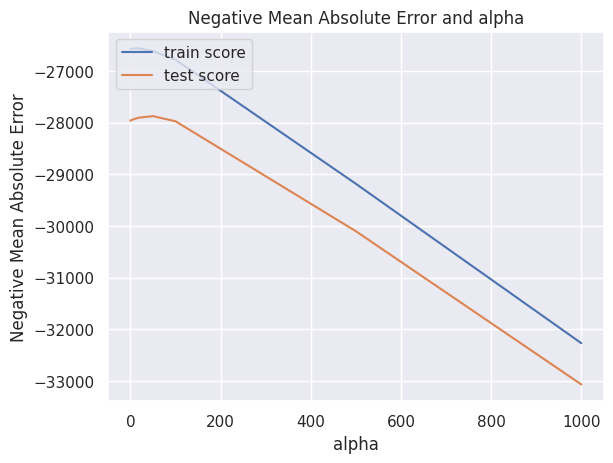

In [1018]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [1019]:
best_alpha = model_cv.best_params_
best_alpha

{'alpha': 50}

In [1020]:
ridge = Ridge(alpha=50)

ridge.fit(x_train, y_train)
ridge.coef_

array([  -752.99249312,  -1040.48141779,  -1040.48141779,   -752.99249312,
        -3831.39386737,  -5230.49110886, -11445.61741708, -15529.35461193,
        -9604.34878098,   4993.38643443,  21919.92989036,  20743.91881234,
        22249.87409468,   -143.18286257,  -3155.0417431 ,  -2805.39886665,
         1189.9876961 ,   -555.21458515,    892.47447034,    982.5878549 ,
          480.52808505,    -84.206198  ,   -269.36081464,    -84.206198  ,
         -269.36081464,      0.        ,  -1970.15215996,  -1679.67106552,
        -1679.67106552,      0.        ,  -4120.56555119,  -9477.36610607,
       -11477.41040054, -10493.50802879,  -4851.5818525 ,   7347.0238799 ,
         2635.41045279,   8501.76581664,  -1692.99745015,  -6817.04369482,
        -1775.88263942,   1474.30392502,    206.50593743,   3421.89920154,
         -399.05270225,    -37.06379354,   -531.50948469,   3310.85603696,
         3398.71318402,   3398.71318402])

In [1021]:
y_train_pred = ridge.predict(x_train)
y_test_pred =ridge.predict(x_test)

print("y_train  r2",metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
print("y_test  r2",metrics.r2_score(y_true=y_test, y_pred=y_test_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

y_train  r2 0.7598186125692196
y_test  r2 0.7631988815621915
RMSE : 39041.327136640924


In [1022]:
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
cols = x_train.columns.insert(0, "constant")
df = pd.DataFrame(list(zip(cols,model_parameters)))
df.columns = ['Variable', 'Coeff']
df["abs_Coeff"] = df['Coeff'].abs()
df = pd.DataFrame(df[(df['Coeff'] != 0)])
res=df.sort_values(by=['abs_Coeff'], ascending = False)
print("shape of model",res.shape)
res.head(10)

shape of model (49, 3)


Variable          Coeff      abs_Coeff
0         constant  180609.596474  180609.596474
13  OverallQual_10   22249.874095   22249.874095
11   OverallQual_8   21919.929890   21919.929890
12   OverallQual_9   20743.918812   20743.918812
8    OverallQual_5  -15529.354612   15529.354612
33  TotRmsAbvGrd_5  -11477.410401   11477.410401
7    OverallQual_4  -11445.617417   11445.617417
34  TotRmsAbvGrd_6  -10493.508029   10493.508029
9    OverallQual_6   -9604.348781    9604.348781
32  TotRmsAbvGrd_4   -9477.366106    9477.366106

#Test for double value of Alpha

In [1023]:

ridge_2 = Ridge(alpha=100)

ridge_2.fit(x_train, y_train)
y_train_pred = ridge_2.predict(x_train)
y_test_pred =ridge_2.predict(x_test)

print("y_train  r2",metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
print("y_test  r2",metrics.r2_score(y_true=y_test, y_pred=y_test_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

y_train  r2 0.7570272439806756
y_test  r2 0.7583746917945554
RMSE : 39437.00342264878


In [1024]:
model_parameters = list(ridge_2.coef_)
model_parameters.insert(0, ridge_2.intercept_)
cols = x_train.columns.insert(0, "constant")
df = pd.DataFrame(list(zip(cols,model_parameters)))
df.columns = ['Variable', 'Coeff']
df["abs_Coeff"] = df['Coeff'].abs()
df = pd.DataFrame(df[(df['Coeff'] != 0)])
res=df.sort_values(by=['abs_Coeff'], ascending = False)
print("shape of model",res.shape)
res.head(10)

shape of model (49, 3)


Variable          Coeff      abs_Coeff
0         constant  180609.596474  180609.596474
13  OverallQual_10   21148.742184   21148.742184
11   OverallQual_8   20843.383046   20843.383046
12   OverallQual_9   19671.255149   19671.255149
8    OverallQual_5  -14721.765486   14721.765486
7    OverallQual_4  -10760.428399   10760.428399
33  TotRmsAbvGrd_5  -10551.677032   10551.677032
34  TotRmsAbvGrd_6   -9442.090544    9442.090544
9    OverallQual_6   -9238.949789    9238.949789
32  TotRmsAbvGrd_4   -8748.961592    8748.961592

## Removing top 5 feature and test 
### Feature removing (PoolQC_Gd FullBath_3 OverallQual_9 OverallQual_10 Fireplaces_3 )

### Ridge reggresion model

In [1025]:
x_train_1=x_train.drop(["OverallQual_10","OverallQual_8","OverallQual_9","OverallQual_5","TotRmsAbvGrd_5"],axis=1)

x_test_1=x_test.drop(["OverallQual_10","OverallQual_8","OverallQual_9","OverallQual_5","TotRmsAbvGrd_5"],axis=1)
model_cv1 = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv1.fit(x_train_1, y_train) 
print("best alpha", model_cv1.best_params_)

ridge3 = Ridge(alpha=500)



Fitting 5 folds for each of 28 candidates, totalling 140 fits
best alpha {'alpha': 500}


In [1026]:
ridge3.fit(x_train_1, y_train)

ridge3.fit(x_train_1, y_train)
y_train_pred = ridge3.predict(x_train_1)
y_test_pred =ridge3.predict(x_test_1)

model_parameters = list(ridge3.coef_)
model_parameters.insert(0, ridge3.intercept_)
cols = x_train_1.columns.insert(0, "constant")
df1 = pd.DataFrame(list(zip(cols,model_parameters)))
df1.columns = ['Variable', 'Coeff']
df1["abs_Coeff"] = df1['Coeff'].abs()
df1 = pd.DataFrame(df1[(df1['Coeff'] != 0)])
res1=df1.sort_values(by=['abs_Coeff'], ascending = False)
print("shape of model",res.shape)
res1.head(10)

shape of model (49, 3)


Variable          Coeff      abs_Coeff
0                constant  180609.596474  180609.596474
31        TotRmsAbvGrd_10   13072.553709   13072.553709
35       FireplaceQu_none  -12727.370067   12727.370067
33           Fireplaces_2    9547.510158    9547.510158
8           OverallQual_6   -8226.727951    8226.727951
32           Fireplaces_1    7495.878594    7495.878594
44           SaleType_New    6898.507241    6898.507241
45  SaleCondition_Partial    6898.507241    6898.507241
7           OverallQual_4   -6748.450444    6748.450444
13          OverallCond_5    6722.809581    6722.809581

## Lasso reggression

In [1027]:

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000,2000,4000 ]}
lasso = Lasso()


model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(x_train, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000, 2000, 4000]},
             return_train_score=True, scoring='r2', verbose=1)

In [1028]:
# cv_results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.094867      0.005106         0.007573        0.003962      0.0001   
1       0.037820      0.013581         0.002423        0.000125       0.001   
2       0.040208      0.011416         0.002052        0.000142        0.01   
3       0.047213      0.017872         0.003035        0.000891        0.05   
4       0.049046      0.012999         0.004191        0.002621         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.760866           0.699497           0.701354   
1   {'alpha': 0.001}           0.760866           0.699497           0.701354   
2    {'alpha': 0.01}           0.760866           0.699498           0.701354   
3    {'alpha': 0.05}           0.760867           0.699498           0.701355   
4     {'alpha': 0.1}           0.760869           0.699499           0.701356   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.745231  ...         0.731996        0.026253               29   
1           0.745231  ...         0.731996        0.026253               28   
2           0.745239  ...         0.731998        0.026254               27   
3           0.745274  ...         0.732005        0.026258               26   
4           0.745317  ...         0.732014        0.026262               25   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.756884            0.772346            0.768866   
1            0.756884            0.772346            0.768866   
2            0.756884            0.772346            0.768866   
3            0.756884            0.772346            0.768866   
4            0.756884            0.772346            0.768866   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.760181            0.761385          0.763932         0.005751  
1            0.760181            0.761385          0.763932         0.005751  
2            0.760181            0.761385          0.763932         0.005751  
3            0.760181            0.761385          0.763932         0.005751  
4            0.760181            0.761385          0.763932         0.005751  

[5 rows x 21 columns]

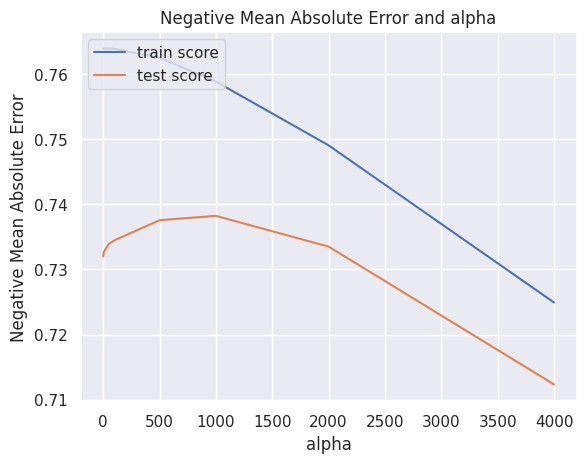

In [1029]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [1030]:
best_alpha = model_cv.best_params_
best_alpha

{'alpha': 1000}

In [1031]:
# lasso regression
lasso = Lasso(alpha=1000)
lasso.fit(x_train, y_train)
# prediction on the test set(Using R2)
y_train_pred = lasso.predict(x_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso.predict(x_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

0.7561042239674792
0.7577291015843524
RMSE : 39489.65345273759


### Test with double Alpha = 2000

In [1032]:
lasso_2 = Lasso(alpha=2000)
lasso_2.fit(x_train, y_train)

# prediction on the test set(Using R2)
y_train_pred = lasso_2.predict(x_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso_2.predict(x_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

0.7469571357195988
0.7438393125313012
RMSE : 40605.88101387955


In [1033]:
# lasso model parameters
model_parameters = list(lasso_2.coef_ )
model_parameters.insert(0, lasso_2.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = x_train.columns
cols = cols.insert(0, "constant")


In [1034]:
coeff = pd.DataFrame(list(zip(cols, model_parameters)))
coeff.columns = ['Variable', 'Coeff']
coeff = pd.DataFrame(coeff[(coeff['Coeff'] != 0)])
coeff["abs_Coeff"] = coeff['Coeff'].abs()
coeff = coeff.sort_values((['abs_Coeff']), axis = 0, ascending = False)
print("shape of coeff list", coeff.shape)
# top 5 coefficent excluding constant term

coeff.head(10) 

shape of coeff list (23, 3)


Variable       Coeff   abs_Coeff
0           constant  180609.596  180609.596
11     OverallQual_8   30159.748   30159.748
13    OverallQual_10   25331.152   25331.152
12     OverallQual_9   24609.452   24609.452
10     OverallQual_7   14448.538   14448.538
40  FireplaceQu_none  -10581.495   10581.495
36   TotRmsAbvGrd_10    7255.957    7255.957
33    TotRmsAbvGrd_5   -5995.602    5995.602
38      Fireplaces_2    5835.625    5835.625
32    TotRmsAbvGrd_4   -5622.119    5622.119

## Find top 5 feature after removing current top 5 feature

In [1035]:
x_train_1=x_train.drop(["OverallQual_8","OverallQual_10","OverallQual_9","OverallQual_7","TotRmsAbvGrd_5"],axis=1)

x_test_1=x_test.drop(["OverallQual_10","OverallQual_8","OverallQual_9","OverallQual_7","TotRmsAbvGrd_5"],axis=1)
model_cv3 = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv3.fit(x_train_1, y_train) 
print("best alpha", model_cv3.best_params_)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
best alpha {'alpha': 50}


In [1036]:

lasso3 = Lasso(alpha=50)
lasso3.fit(x_train_1, y_train)
# prediction on the test set(Using R2)
y_train_pred = lasso3.predict(x_train_1)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso3.predict(x_test_1)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

0.6262057536813586
0.6008490946806555
RMSE : 50687.544980522434


In [1037]:
# lasso model parameters
model_parameters = list(lasso3.coef_ )
model_parameters.insert(0, lasso3.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = x_train.columns
cols = cols.insert(0, "constant")
coeff = pd.DataFrame(list(zip(cols, model_parameters)))
coeff.columns = ['Variable', 'Coeff']
coeff = pd.DataFrame(coeff[(coeff['Coeff'] != 0)])
coeff["abs_Coeff"] = coeff['Coeff'].abs()
coeff = coeff.sort_values((['abs_Coeff']), axis = 0, ascending = False)
print("shape of coeff list", coeff.shape)
# top 5 coefficent excluding constant term

coeff.head(10) 

shape of coeff list (37, 3)


Variable       Coeff   abs_Coeff
0            constant  180609.596  180609.596
8       OverallQual_5  -35110.309   35110.309
9       OverallQual_6  -28181.104   28181.104
7       OverallQual_4  -23816.859   23816.859
31     TotRmsAbvGrd_3   16416.392   16416.392
35     TotRmsAbvGrd_7  -14781.165   14781.165
44      GarageQual_TA   10719.181   10719.181
6       OverallQual_3  -10375.894   10375.894
33     TotRmsAbvGrd_5    8707.870    8707.870
29  BsmtFinType1_none   -6653.005    6653.005

The high values of positive coeeficients indicate that feature contribute high sale value.

The higher values of -ve coeeficients suggest a nagative impact of that feature on sale value.